# BPL_TEST2_Batch_calibration - demo

Author: Jan Peter Axelsson

This notebook shows the possibilities for calibration of the model BPL_TEST2_Batch using scipy.optimize.minimize() routine. There are several different methods to choose between. In this notebook we work with simulated data.

The text-book model of batch cultivation we simulate is the following where $S$ is substrate, $X$ is cell concentration, and $V$ is volume of the broth

$$
\eqalign{
{d(VS) \over dt} =& -q_S(S) \cdot VX \cr 
{d(VX) \over dt} =& \mu(S) \cdot VX }
$$

and where specific cell growth rate $\mu$ and substrate uptake rate $q_S$ are

$$
\mu(S) = Y \cdot q_S(S)
$$

$$
q_S(S) = q_S^{max} {S \over K_s + S}
$$

where $Y$ is the yield, $q_S^{max}$ is the maximal specific substrate uptake rate and $K_s$ is the corresponding saturation constant.

The parameter estimation is done with optimization methods that only require evaluation of the missmatch between simulation with given parameters and data. At start the allowed range for each parameter is given. The method used for optimization is Nelder-Mead but can easily be changed [1].

In the near future the FMU may provide first derivative gradient informaion, that will make it possible to choose corresponding method of minimize() for improved performance. This possibility is related to the upgrade to the FMI-standard ver 3.0 for the Modelica compiler.  

The Python package PyFMI [2] that is the base for FMU-explore has a simplified built-in
functionality for parameter estimation that also use scipy.optimize.minimize(). However, there is estimatation functionaly but the purpose seems to only address smaller examples. There is for instance no support to handle models that takes sub-models from libraries and necesssary changes of default parameters not to be estimated. Therefore we here define a Python function evaluate() that facilitate the formulation of the parameter estimation and also bring flexibility to choice of optimization method, default Nelder-Mead.

In [1]:
run -i BPL_TEST2_Batch_explore.py

Linux - run FMU pre-compiled OpenModelica

Model for the process has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
# Adjust the size of diagrams
plt.rcParams['figure.figsize'] = [15/2.54, 12/2.54]

No processDiagram.png file in the FMU, but try the file on disk.


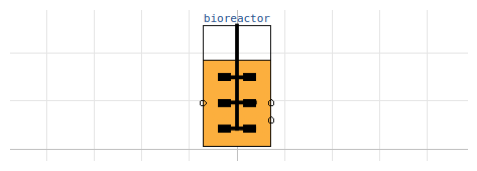

In [3]:
process_diagram()

## 1 Generate data later used for parameter estimation

In [4]:
import pandas as pd

Could not find cannot import name 'dopri5' from 'assimulo.lib' (/home/janpeter/miniconda3/envs/pyfmi/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (/home/janpeter/miniconda3/envs/pyfmi/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (/home/janpeter/miniconda3/envs/pyfmi/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


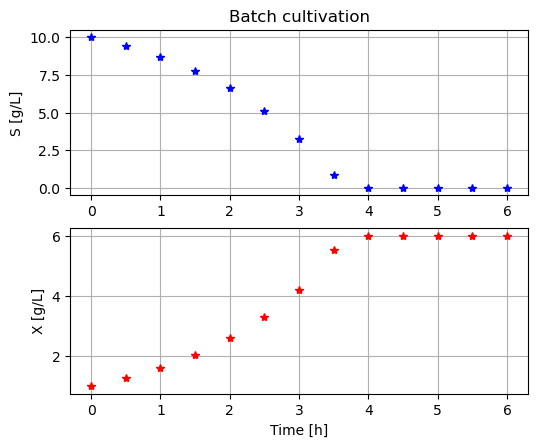

In [5]:
# Data generated
simulationTime = 6.0
par(Y=0.50, qSmax=1.00, Ks=0.1)
init(V_start=1.0, VS_start=10, VX_start=1.0)
newplot(plotType='Demo_2')
simu(simulationTime, options=opts_data)

In [6]:
# Store data in a DataFrame for later use
data = pd.DataFrame(data={'time':sim_res['time'], 'X':sim_res['bioreactor.c[1]'], 'S':sim_res['bioreactor.c[2]']})
data

,time,X,S
0,0.0,1.000000,1.000000e+01
1,0.5,1.269848,9.438455e+00
2,1.0,1.615795,8.719839e+00
3,1.5,2.050445,7.800734e+00
4,2.0,2.601038,6.626389e+00
5,2.5,3.297304,5.128962e+00
6,3.0,4.195962,3.229259e+00
7,3.5,5.524388,8.813998e-01
8,4.0,6.000000,-2.037810e-08
9,4.5,6.000000,2.960320e-10


## 2 Simulation with initial guess of parameters compared with data

Here we define the parameters that should be estimated and specify allowed ranges. 
Nominal parameters are chosen as the mid-point of the allowed parameter range. 

Simulation with these nominal parameter set and compare with data give an idea of who well the model fit data.

In [7]:
# Parameters to be estimated using parDict names and their bounds
parEstim = ['Y', 'qSmax', 'Ks']
parBounds = [(0.4, 0.8), (0.7, 1.3), (0.05, 0.20)]
parEstim_0 = [np.mean(parBounds[k]) for k in range(len(parBounds))]

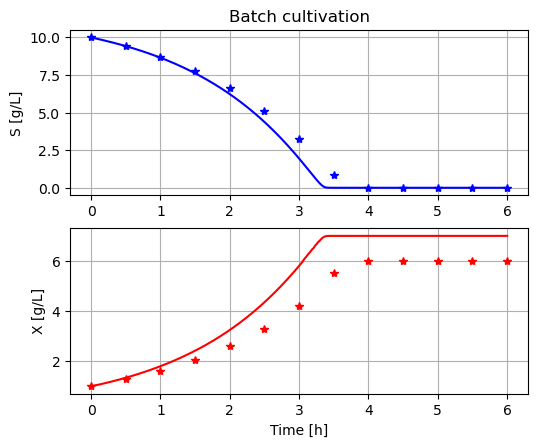

In [8]:
# Simulation with nominal parameters
newplot(plotType='Demo_1')
par(Y=parEstim_0[0], qSmax=parEstim_0[1], Ks=parEstim_0[2])
simu(simulationTime)

# Show data
ax1.plot(data['time'], data['S'],'b*')
ax2.plot(data['time'], data['X'],'r*')
plt.show()

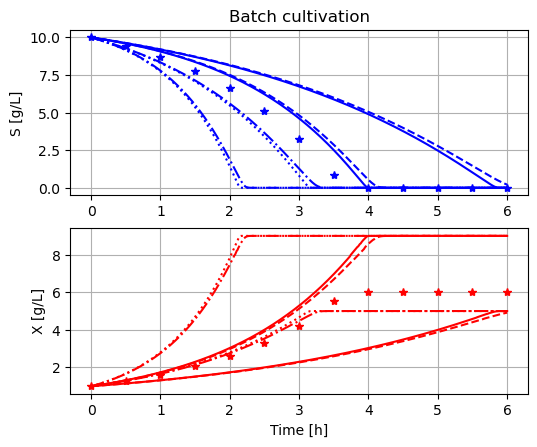

In [9]:
# Simulation over the parameter ranges given
newplot(plotType='Demo_1')
for Y_value in parBounds [0]:
    for qSmax_value in parBounds[1]:
        for Ks_value in parBounds[2]:
            par(Y=Y_value, qSmax=qSmax_value, Ks=Ks_value)
            simu(simulationTime)
            
# Show data
ax1.plot(data['time'], data['S'],'b*')
ax2.plot(data['time'], data['X'],'r*')
plt.show()

Simulation over the diferent parameter combinations of the parameter bounds shows that data is "covered" and we have good hope to find a parameter combination that fits data well.

## 3 Parameter estimation

Here we use the scipy.optimize.minimize() procedure which contain a family of different methods [1].
The default method is Nelder-Mead and is robust for fitting a model to data. Further we have chosen to work with bounds for the parameters to be estimated and the initial guess is chosen as the middle point in parameter space.

In [10]:
# Optimization routine import
import scipy.optimize

In [11]:
# Parameters to be estimated using parDict names and their bounds
extra_args = (parEstim, data, fmu_model, simulationTime)

In [12]:
# Modified evaluation function tailored for Python optimization algorithms
def objective(x, parEstim, data=data, fmu_model=fmu_model, simulationTime=simulationTime):
    """The parameter list is tailored for scipy optimization algorithms interface, 
       where the first parameter x is an array with parameters that are tuned 
       and evalauted and parEstim is a list of the names of these parameters.
       The code can be made 20-30% faster, but longer, using pyfmi-commands directly."""
    
    # Update parameters and simulate
    for i, p in enumerate(parEstim): par(**{p:x[i]})
    simu(simulationTime, options=opts_fast)
 
    # Calculate loss function V
    V={}
    V['X'] = np.linalg.norm(data['X'] - np.interp(data['time'], sim_res['time'], sim_res['bioreactor.c[1]']))
    V['S'] = np.linalg.norm(data['S'] - np.interp(data['time'], sim_res['time'], sim_res['bioreactor.c[2]']))
  
    return V['X'] + V['S']

In [13]:
import time

In [14]:
# Run minimize()
start_time = time.time()
result = scipy.optimize.minimize(objective, x0=parEstim_0, args=extra_args, 
                                 method='Nelder-Mead', bounds=parBounds, options={"disp":True})
print('CPU-time =', time.time()-start_time)

Optimization terminated successfully.
         Current function value: 0.148311
         Iterations: 66
         Function evaluations: 122
CPU-time = 2.1972687244415283


In [15]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.14831099409281864
             x: [ 5.000e-01  1.007e+00  1.438e-01]
           nit: 66
          nfev: 122
 final_simplex: (array([[ 5.000e-01,  1.007e+00,  1.438e-01],
                       [ 5.000e-01,  1.007e+00,  1.437e-01],
                       [ 4.999e-01,  1.007e+00,  1.438e-01],
                       [ 5.000e-01,  1.007e+00,  1.437e-01]]), array([ 1.483e-01,  1.483e-01,  1.483e-01,  1.483e-01]))

The estimated parameters result.x are very close to the original values and no surprise.

## 4 Simulation with estimated parameters compared with data

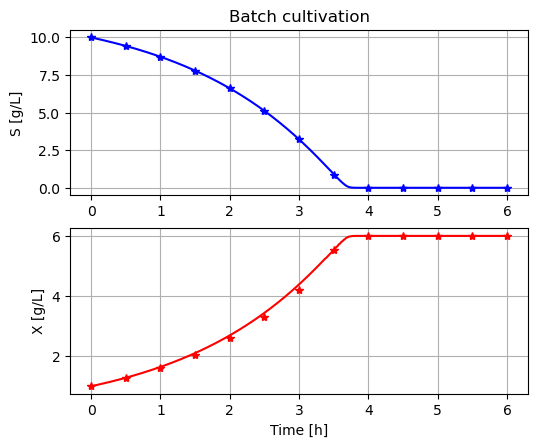

In [16]:
newplot(plotType='Demo_1')
par(Y=result.x[0], qSmax=result.x[1], Ks=result.x[2])
simu(simulationTime)

# Show data
ax1.plot(data['time'], data['S'],'b*')
ax2.plot(data['time'], data['X'],'r*')
plt.show()

In [17]:
# The estimated parameters are
for i in range(len(parEstim)): print(parEstim[i],':', result.x[i])

Y : 0.4999727558733863
qSmax : 1.0073152667279195
Ks : 0.14380564144282715


## 5 Analysis of the loss function

The problem is small and analysis of the loss function brings some insight. From the diagram above showing parameter sweep over combinations min- and max-parameters we see that the parameter $K_s$ has little influence. Let use set that a fixed value and then plot the loss function in the parameters $Y$ and $qSmax$.  We do this by go through all the parametera combinations and evaluate each of them.

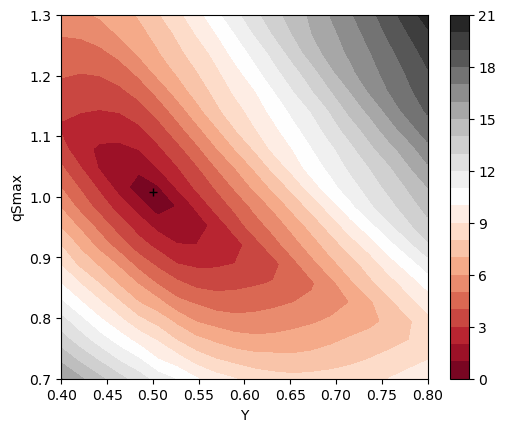

In [18]:
# Sweep through Y and qSmax variation and store the value of the loss-function for each
nY = 20
nqSmax = 20
V = np.zeros((nY, nqSmax))
             
Y = np.linspace(parBounds[0][0],parBounds[0][1],nY)
qSmax = np.linspace(parBounds[1][0],parBounds[1][1],nqSmax)

for j in range(nY):
    for k in range(nqSmax):
        V[k,j] = objective([Y[j], qSmax[k], 0.1], parEstim)

# Contour plot
plt.figure()
plt.clf
plt.subplot(1,1,1)
plt.contourf(Y, qSmax, V, 20, cmap='RdGy')
plt.plot(result.x[0], result.x[1],'k+')
plt.colorbar()
plt.ylabel('qSmax')
plt.xlabel('Y')
plt.show()

We see the following in the contour diagram of the loss function simplified:
* The minima is unique in the range of parmaters we study. This is good news.
* The contour plot is ellipsoid and rather narrow. The more narrow the ellipsoid the more difficult and more time it takes to converge to the minima.
* The direction of the ellipsoid axis indicate the correlation you may get between the two parameters during the minimization process.

Note that the form of the contour plot change with the parameters (and initial values) of the actual proces.
You can see the impact by changing the parameters in "cell # 4" where data is generated and then just choose to run that cell and the cells below. No need to restart the notebook.

## 6 Summary

A choice was made to work with allowed ranges of parameters to be estimated and a start value was defined as the center point in this parameter space. There are only three methods available in optimize.minimize() that can handle bounds on parameters.

An evaluate() function was created that define how the difference beween simulation and data is measured. The function is rather transparent and easy to modify and you may want to change weight on the loss in S and X, for instance. Here they have so far equal weight. 

The FMU-explore workspace dictionaries partDict[] and parLocation[] are useful also here and simplify the code for the evaluation() function. But we also use the detailed PyFMI-functions to administrate and set parameters of the actual simulation. 

The call optimize.minimize() has several parameters and can easily be modified, for instance change of method. For fitting a model to data Nelder-Mead is ao a robust and good choice, but can be somewhat slow.

The estimated parameters were close to perfect!

The contour plot of the simplified loss function shows that the minima is unique and should
not be difficult too difficut to obtain. More narrow ellipticaL contour plots would indicate difficulties. Multiple local minima would also be a problem.

## 7 References

[1] Scipy Reference guide on optimize.minimize()
[here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html?highlight=minimize)

[2] Andersson, C., Åkesson, J., Fuhrer C. : "PyFMI: A Python package for simulation of coupled dynamic models with the functional mock-up interface", Centre for Mathematical Sciences, Lund University, Report LUTFNA-5008-2016, 2016. 

## Appendix

In [19]:
describe('parts')

['bioreactor', 'bioreactor.culture']


In [20]:
describe('MSL')

MSL: 4.1.0 - used components: none


In [21]:
system_info()


System information
 -OS: Linux
 -Python: 3.12.9
 -Scipy: 1.16.1
 -PyFMI: 2.18.0
 -FMU by: OpenModelica Compiler OpenModelica 1.26.0~dev-200-gcb3254b
 -FMI: 2.0
 -Type: FMUModelME2
 -Name: BPL.Examples_TEST2.Batch
 -Generated: 2025-07-28T07:58:02Z
 -MSL: 4.1.0
 -Description: Bioprocess Library version 2.3.1
 -Interaction: FMU-explore version 1.0.0


In [22]:
#!jupyter nbconvert --to webpdf BPL_TEST2_Batch_calibration.ipynb

In [23]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 24.04.3 LTS
Release:	24.04
Codename:	noble
